# 06 Complicated Count

The last network was trying to count the number of 1s in a string, which means that it could have just learned that $r_i =x_i$. Just to make sure that it is actually counting the occurrences of things and not just copying the string, here the network will count the number of occurrences of nonnegative integers in a string. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_context('paper')
sns.set_style("darkgrid")


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from random import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'

import pickle

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''
        self.hidden = hidden
        #this LSTM goes from input [batch x length x 1] to output [batch x length x hidden]
        self.lstm = nn.LSTM(1, hidden, batch_first=True).double().cuda() 

        #this matrix transforms from [1 x hidden] to [1 x 1]
        self.combine = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.lstm.parameters())
        params.append(self.combine)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.
        Shape: [batch x length x 1]'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the actual sum of the tensor. 
        Returns the loss and the predicted sum'''

        h = torch.zeros([1,sequence.shape[0],self.hidden]).double().cuda()
        c = torch.zeros([1,sequence.shape[0],self.hidden]).double().cuda()

        o, _ = self.lstm(sequence)
        add = torch.sigmoid(o @ self.combine)
        count = add.sum(1).squeeze(1)
        true = self.true_sum(sequence)
        loss = (count - true).pow(2)
        return loss, count

    def predict_multilength(self, sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        count= torch.tensor(0, device=device).double()
        for s in sequences:
            res    = self.predict(s)[0]
            count += res.shape[0]
            loss  += res.sum()
        return loss / count

    @staticmethod
    def true_sum(sequence):
        '''Determines the true sums of a batch of sequences to train against'''
        comp = (sequence >= 0).float()
        comp = comp.sum(1).squeeze(1)
        return comp

## Data Generation

In [0]:
def generate_data(length, total):
    counts = np.random.dirichlet((np.arange(length)+1)**2) * total * 0.9
    counts = np.round(counts).astype(int)

    train_set = []
    val_set = []
    test_set = []

    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(-10,10, size=[counts[i-1],i])
        seqs = np.unique(seqs, axis=0)
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            continue

    counts = np.random.dirichlet((np.arange(length, 2*length)+1)**2) * total * 0.1
    counts = np.round(counts).astype(int)
    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = np.random.randint(-10,10, size=[counts[i],i+length+1])
        seqs = np.unique(seqs, axis=0)
        test = Counter.convert_sequence(seqs)
        test_set.append(test)

    return train_set, val_set, test_set


In [0]:
#generate all the strings and partition into train and test
length = 64
hidden = 10
depth = 100000

output_folder = "Part-6-Outputs"

In [0]:
# train, val, test = generate_data(length,depth)

# with open("%s/Data.pickle"%output_folder, "wb") as f:
#     pickle.dump([train, val, test], f)

In [0]:
with open("%s/Data.pickle"%output_folder, "rb") as f:
    train, val, test = pickle.load(f)

In [0]:
trainsize = sum([x.shape[0] for x in train])
valsize = sum([x.shape[0] for x in val])
testsize = sum([x.shape[0] for x in test])
print(trainsize, valsize, testsize)

total = trainsize+valsize+testsize
print("Total:",total)
print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))

print("Train    string range: %d-%d"%(min([x.shape[1] for x in train]), max([x.shape[1] for x in train])))
print("Validate string range: %d-%d"%(min([x.shape[1] for x in val]), max([x.shape[1] for x in val])))
print("Test     string range: %d-%d"%(min([x.shape[1] for x in test]), max([x.shape[1] for x in test])))

69974 20029 9996
Total: 99999
Fraction 0.700 0.200 0.100
Train    string range: 2-64
Validate string range: 2-64
Test     string range: 65-128


## Model Training

In [0]:
#train over all the training data
model = Counter(hidden=hidden)

history = []
best = float('inf')
patience = 10
tol = 0.001
count = 0

for epoch in range(1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 100 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f"%(epoch, train_loss, val_loss))

        if val_loss + tol < best:
            best = val_loss
            count = 0
        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

# history = np.array(history)
# np.save("%s/Train-History"%output_folder, history)
# torch.save(model, "%s/Model"%output_folder)

# #display testing results
# loss = model.predict_multilength(test)
# print("Average Test Loss:", loss.item())

## Results Evaluation

The deliverable here is the same as in the previous notebook.

In [0]:
history = np.load("%s/Train-History.npy"%output_folder)
train_loss = history[:,0]
val_loss = history[:,1]
model = torch.load("%s/Model"%output_folder)

In [0]:
loss = model.predict_multilength(test)
print("Average Test Loss:", loss.item())

Average Test Loss: 0.0014292939812155382


In [0]:
res = []
rs = []
inds = list(range(50,1000,50))+list(range(1000,10000,50))#+list(range(1000,10000,1000))
for length in inds:
    seq = np.random.randint(-10,10,size=(1,length,1))
    true = (seq >= 0).sum()
    seq = torch.tensor(seq).double().cuda()
    pred = model.predict(seq)[1].item()
    res.append([length, true, pred])
    o, _ = model.lstm(test[-1][0:1])
    add = torch.sigmoid(o @ model.combine)
    rs.extend(add.squeeze().tolist())
res = pd.DataFrame(res, columns=["Length", "True", "Predicted"])
res["Error"] = np.abs(res["True"] - res["Predicted"]) / res["Length"]

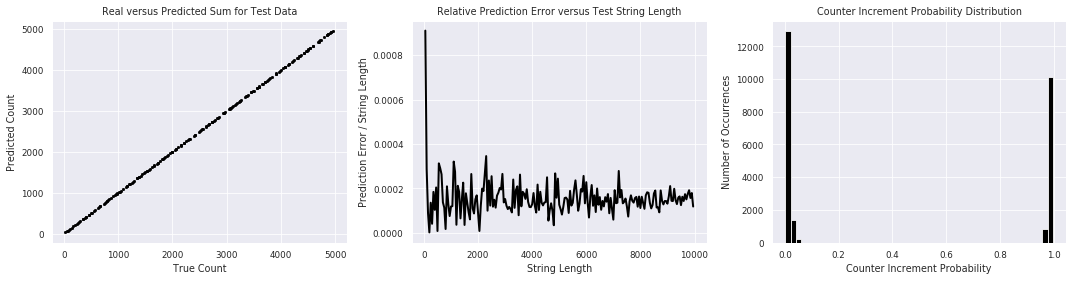

In [0]:
plt.figure(figsize=(15,4))
# sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
# sns.set_style("ticks")
plt.subplot(1,3,1)
plt.scatter(res["True"], res["Predicted"], s=5,color='k', edgecolor='k')
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("Real versus Predicted Sum for Test Data")
plt.subplot(1,3,2)
plt.plot(res["Length"], res["Error"], linewidth=2, color='k')
plt.xlabel("String Length")
plt.ylabel("Prediction Error / String Length")
plt.title("Relative Prediction Error versus Test String Length")
plt.subplot(1,3,3)
plt.hist(rs, bins=50,color='k')
plt.xlabel("Counter Increment Probability")
plt.ylabel("Number of Occurrences")
plt.title("Counter Increment Probability Distribution")
plt.tight_layout()
plt.savefig("Figures/06-plot1.png", dpi=300)
